In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

# Load the Dataset

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data,dtype=object)

In [3]:
train = get_training_data('Dataset/train')
test = get_training_data('Dataset/test')
val = get_training_data('Dataset/val')

In [4]:
print(f'Before division of 80:20')
print(f'Total number of training images = {len(train)}')
print(f'Total number of validation images = {len(val)}\n')


combined_array = np.concatenate((train, val))
np.random.shuffle(combined_array)
print(f'Total number of images : training_images + validation_images = {len(combined_array)}\n')

train = combined_array[:int(len(combined_array) * 0.8)]
val = combined_array[int(len(combined_array) * 0.8):]
print(f'After division of 80:20')
print(f'Total number of training images = {len(train)}')
print(f'Total number of validation images = {len(val)}')

Before division of 80:20
Total number of training images = 5216
Total number of validation images = 16

Total number of images : training_images + validation_images = 5232

After division of 80:20
Total number of training images = 4185
Total number of validation images = 1047


# Data Visualization and Pre-processing

<AxesSubplot:ylabel='count'>

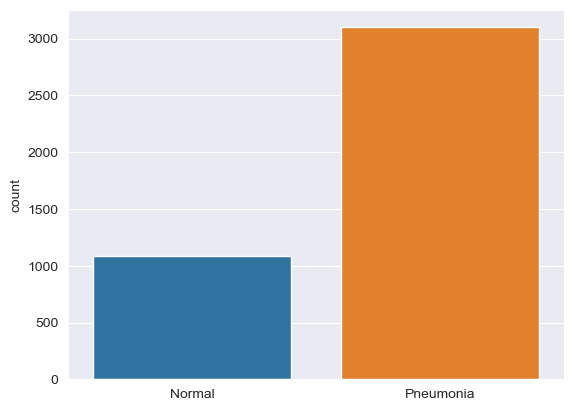

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)

Text(0.5, 1.0, 'PNEUMONIA')

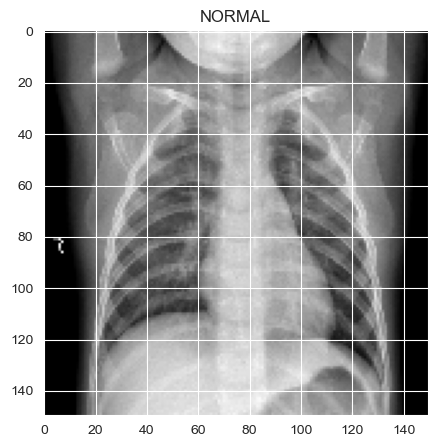

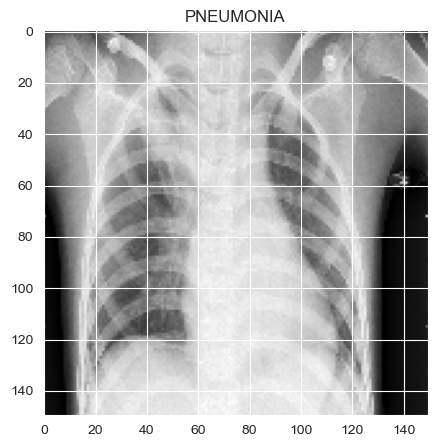

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [9]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [10]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        )


datagen.fit(x_train)

For the data augmentation, i choosed to :

->Randomly rotate some training images by 30 degrees

->Randomly Zoom by 20% some training images

->Randomly shift images horizontally by 10% of the width

->Randomly shift images vertically by 10% of the height

In [22]:
x_train.shape

(4185, 150, 150, 1)

# Training the Model

In [11]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [13]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,
                    epochs = 20 , 
                    validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/20
131/131 [==============================] - 79s 595ms/step - loss: 0.7381 - accuracy: 0.8308 - val_loss: 6.7035 - val_accuracy: 0.7479 - lr: 0.0010
Epoch 2/20
131/131 [==============================] - 80s 607ms/step - loss: 0.2871 - accuracy: 0.8930 - val_loss: 14.3991 - val_accuracy: 0.7479 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.2459 - accuracy: 0.9166
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 80s 607ms/step - loss: 0.2459 - accuracy: 0.9166 - val_loss: 6.1745 - val_accuracy: 0.7479 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 79s 606ms/step - loss: 0.1516 - accuracy: 0.9443 - val_loss: 2.3386 - val_accuracy: 0.7755 - lr: 3.0000e-04
Epoch 5/20
131/131 [==============================] - 79s 605ms/step - loss: 0.1461 - accuracy: 0.9501 - val_loss: 10.0909 - val_accuracy: 0.7479 - lr: 3.0000e-04
Epoch 6/20
131/131 [===================

In [14]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 105ms/step - loss: 0.2934 - accuracy: 0.8926
Loss of the model is -  0.2933627963066101
20/20 [==============================] - 2s 114ms/step - loss: 0.2934 - accuracy: 0.8926
Accuracy of the model is -  89.26281929016113 %


# Analysis after Model Training

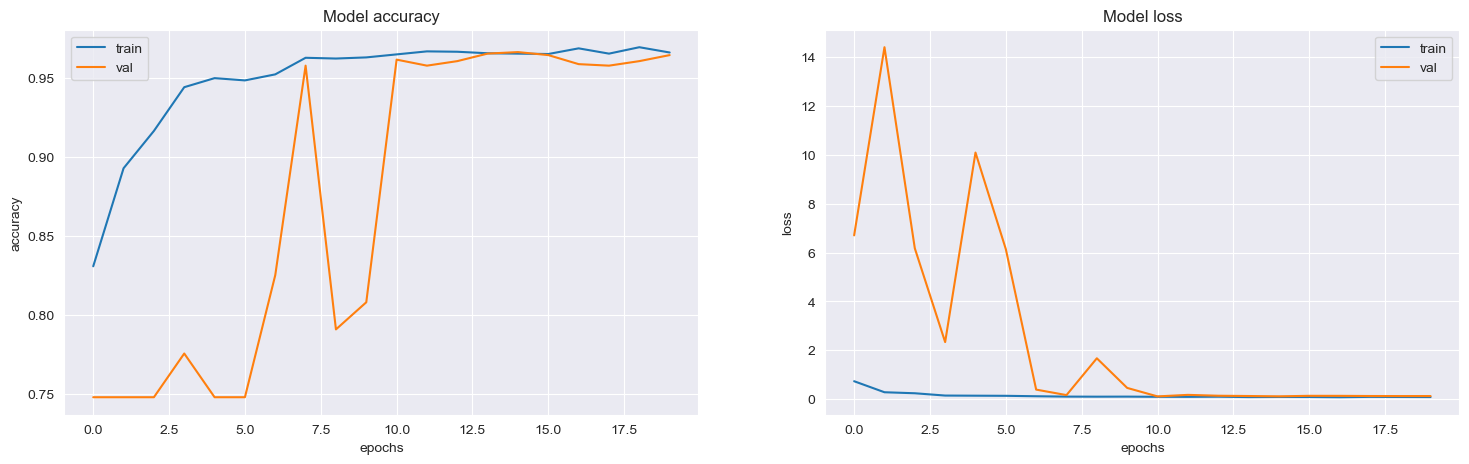

In [15]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history.history[element])
    axis[i].plot(history.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('epochs')
    axis[i].set_ylabel(element)
    axis[i].legend(['train', 'val'])

In [17]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 [==============================] - 2s 105ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [18]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.89      0.91       390
   Normal (Class 1)       0.83      0.89      0.86       234

           accuracy                           0.89       624
          macro avg       0.88      0.89      0.89       624
       weighted avg       0.90      0.89      0.89       624



In [19]:
cm = confusion_matrix(y_test,predictions)
cm

array([[348,  42],
       [ 25, 209]], dtype=int64)

In [20]:
import pandas as pd

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

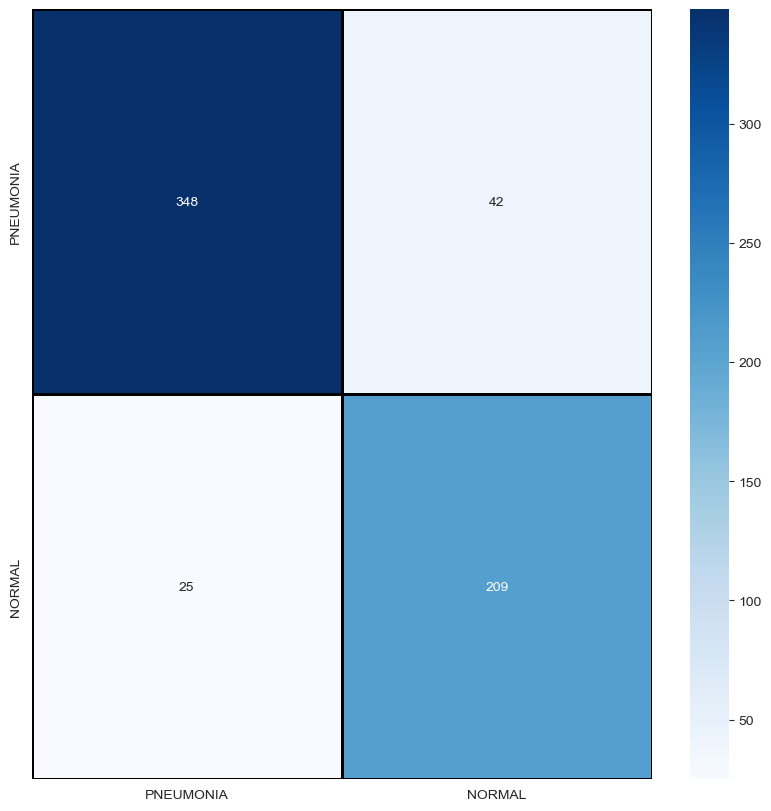

In [21]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)